In [1]:
import os
import time
import datetime

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from tqdm import tqdm

from utils.OpticalFlowUtils import FlowReader
from utils.OpticalFlowUtils import FlowVisualiser

from utils.MPISintelUtils import MPISintelHandler

from assets.ml.src.FlowConv import FlowConvNet
from assets.ml.src.CustomLosses import AE_Loss
from assets.ml.src.CustomLosses import EPE_Loss
from assets.ml.src.CustomCallbacks import PredictOnEpochEndCallback

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 8.1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024*8.1)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(f"Runtime Error: {e}")

1 Physical GPUs, 1 Logical GPUs


In [3]:
reader = FlowReader()
visualiser = FlowVisualiser()
dataHandler = MPISintelHandler()

In [4]:
SINTEL_PATH = os.path.join("..", "Data", "MPI-Sintel")
SINTEL_TRAINING_PATH = os.path.join(SINTEL_PATH, "training")
SINTEL_TRAINING_FLOW_PATH = os.path.join(SINTEL_TRAINING_PATH, "flow")
SINTEL_TRAINING_IMG_PATH = os.path.join(SINTEL_TRAINING_PATH, "clean")

In [5]:
print(f"SINTEL PATH: {SINTEL_PATH}")
print(f"SINTEL TRAINING PATH: {SINTEL_TRAINING_PATH}")
print(f"SINTEL TRAINING FLOW PATH: {SINTEL_TRAINING_FLOW_PATH}")
print(f"SINTEL TRAINING IMG PATH: {SINTEL_TRAINING_IMG_PATH}")

SINTEL PATH: ..\Data\MPI-Sintel
SINTEL TRAINING PATH: ..\Data\MPI-Sintel\training
SINTEL TRAINING FLOW PATH: ..\Data\MPI-Sintel\training\flow
SINTEL TRAINING IMG PATH: ..\Data\MPI-Sintel\training\clean


In [6]:
# load the data from the file after the file has been organised
dataFilepath = os.path.join(".", "assets", "data", "trainImages.data")
trainImgsArray = dataHandler.loadData(dataFilepath)

dataFilepath = os.path.join(".", "assets", "data", "trainFlows.data")
trainFlowsArray = dataHandler.loadData(dataFilepath)

trainImgsArray = trainImgsArray.astype('float32') / 255.0
trainFlowsArray = trainFlowsArray.astype('float32')
trainImgsArray = tf.reshape(trainImgsArray, shape=(-1, 2, 436, 1024, 1))

In [7]:
# Ensure the data has the same shape
print(f"Train images shape: {trainImgsArray.shape}")
print(f"Train flows shape: {trainFlowsArray.shape}")

Train images shape: (1041, 2, 436, 1024, 1)
Train flows shape: (1041, 436, 1024, 2)


In [8]:
# Use tensorboard to visualise training progress and all the fun things
%load_ext tensorboard

In [9]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"FlowConvNET_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch= '10, 110')

modelPath = os.path.join(".", "assets", "ml", "models", "FlowConvNET", "FlowConvNET.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.85, patience=50, min_lr=1e-6)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback]

callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

In [10]:
%tensorboard --logdir ./assets/logs --port=8081

Reusing TensorBoard on port 8081 (pid 18824), started 1:09:51 ago. (Use '!kill 18824' to kill it.)

In [11]:
flowConvNet = FlowConvNet()
angularError = AE_Loss()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
flowConvNet.compile(optimizer=optimizer, loss=EPE_Loss(), metrics = ['mse'])
flowConvNet.build(input_shape=(None, 2, 436, 1024, 1))
flowConvNet.summary()

Model: "flow_conv_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  608       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  73792     
                                                                 
 up_sampling2d (UpSampling2D  multiple                 0         
 )                                                   

In [12]:
hist = flowConvNet.fit(x=trainImgsArray, y=trainFlowsArray, epochs = 250, verbose = False, batch_size=1, validation_split=0.25, callbacks=_callbacks)

In [13]:
def visualiseFits(fits, validationData = True):
    fig, axs = plt.subplots(2, 2, figsize = (40, 20))

    axs[0][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[0][0].legend()
    axs[0][0].set_xlabel("Epochs")
    axs[0][0].set_ylabel("EPE (log Scaled)")
    axs[0][0].set_yscale('log')
    axs[0][0].grid(True)

    axs[1][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[1][0].legend()
    axs[1][0].set_xlabel("Epochs")
    axs[1][0].set_ylabel("EPE")
    axs[1][0].grid(True)

    axs[0][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[0][1].legend()
    axs[0][1].set_xlabel("Epochs")
    axs[0][1].set_ylabel("MSE")
    axs[0][1].grid(True)

    axs[1][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[1][1].legend()
    axs[1][1].set_xlabel("Epochs")
    axs[1][1].set_ylabel("MSE (log scaled)")
    axs[1][1].set_yscale('log')
    axs[1][1].grid(True)
    
    if validationData:
        axs[0][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[1][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[0][1].plot(fits.history['val_mse'], label = "Conventional NN Train MSE validation")
        axs[1][1].plot(fits.history['val_mse'], label = "Conventional NN Train MAE validation")

    plt.show()

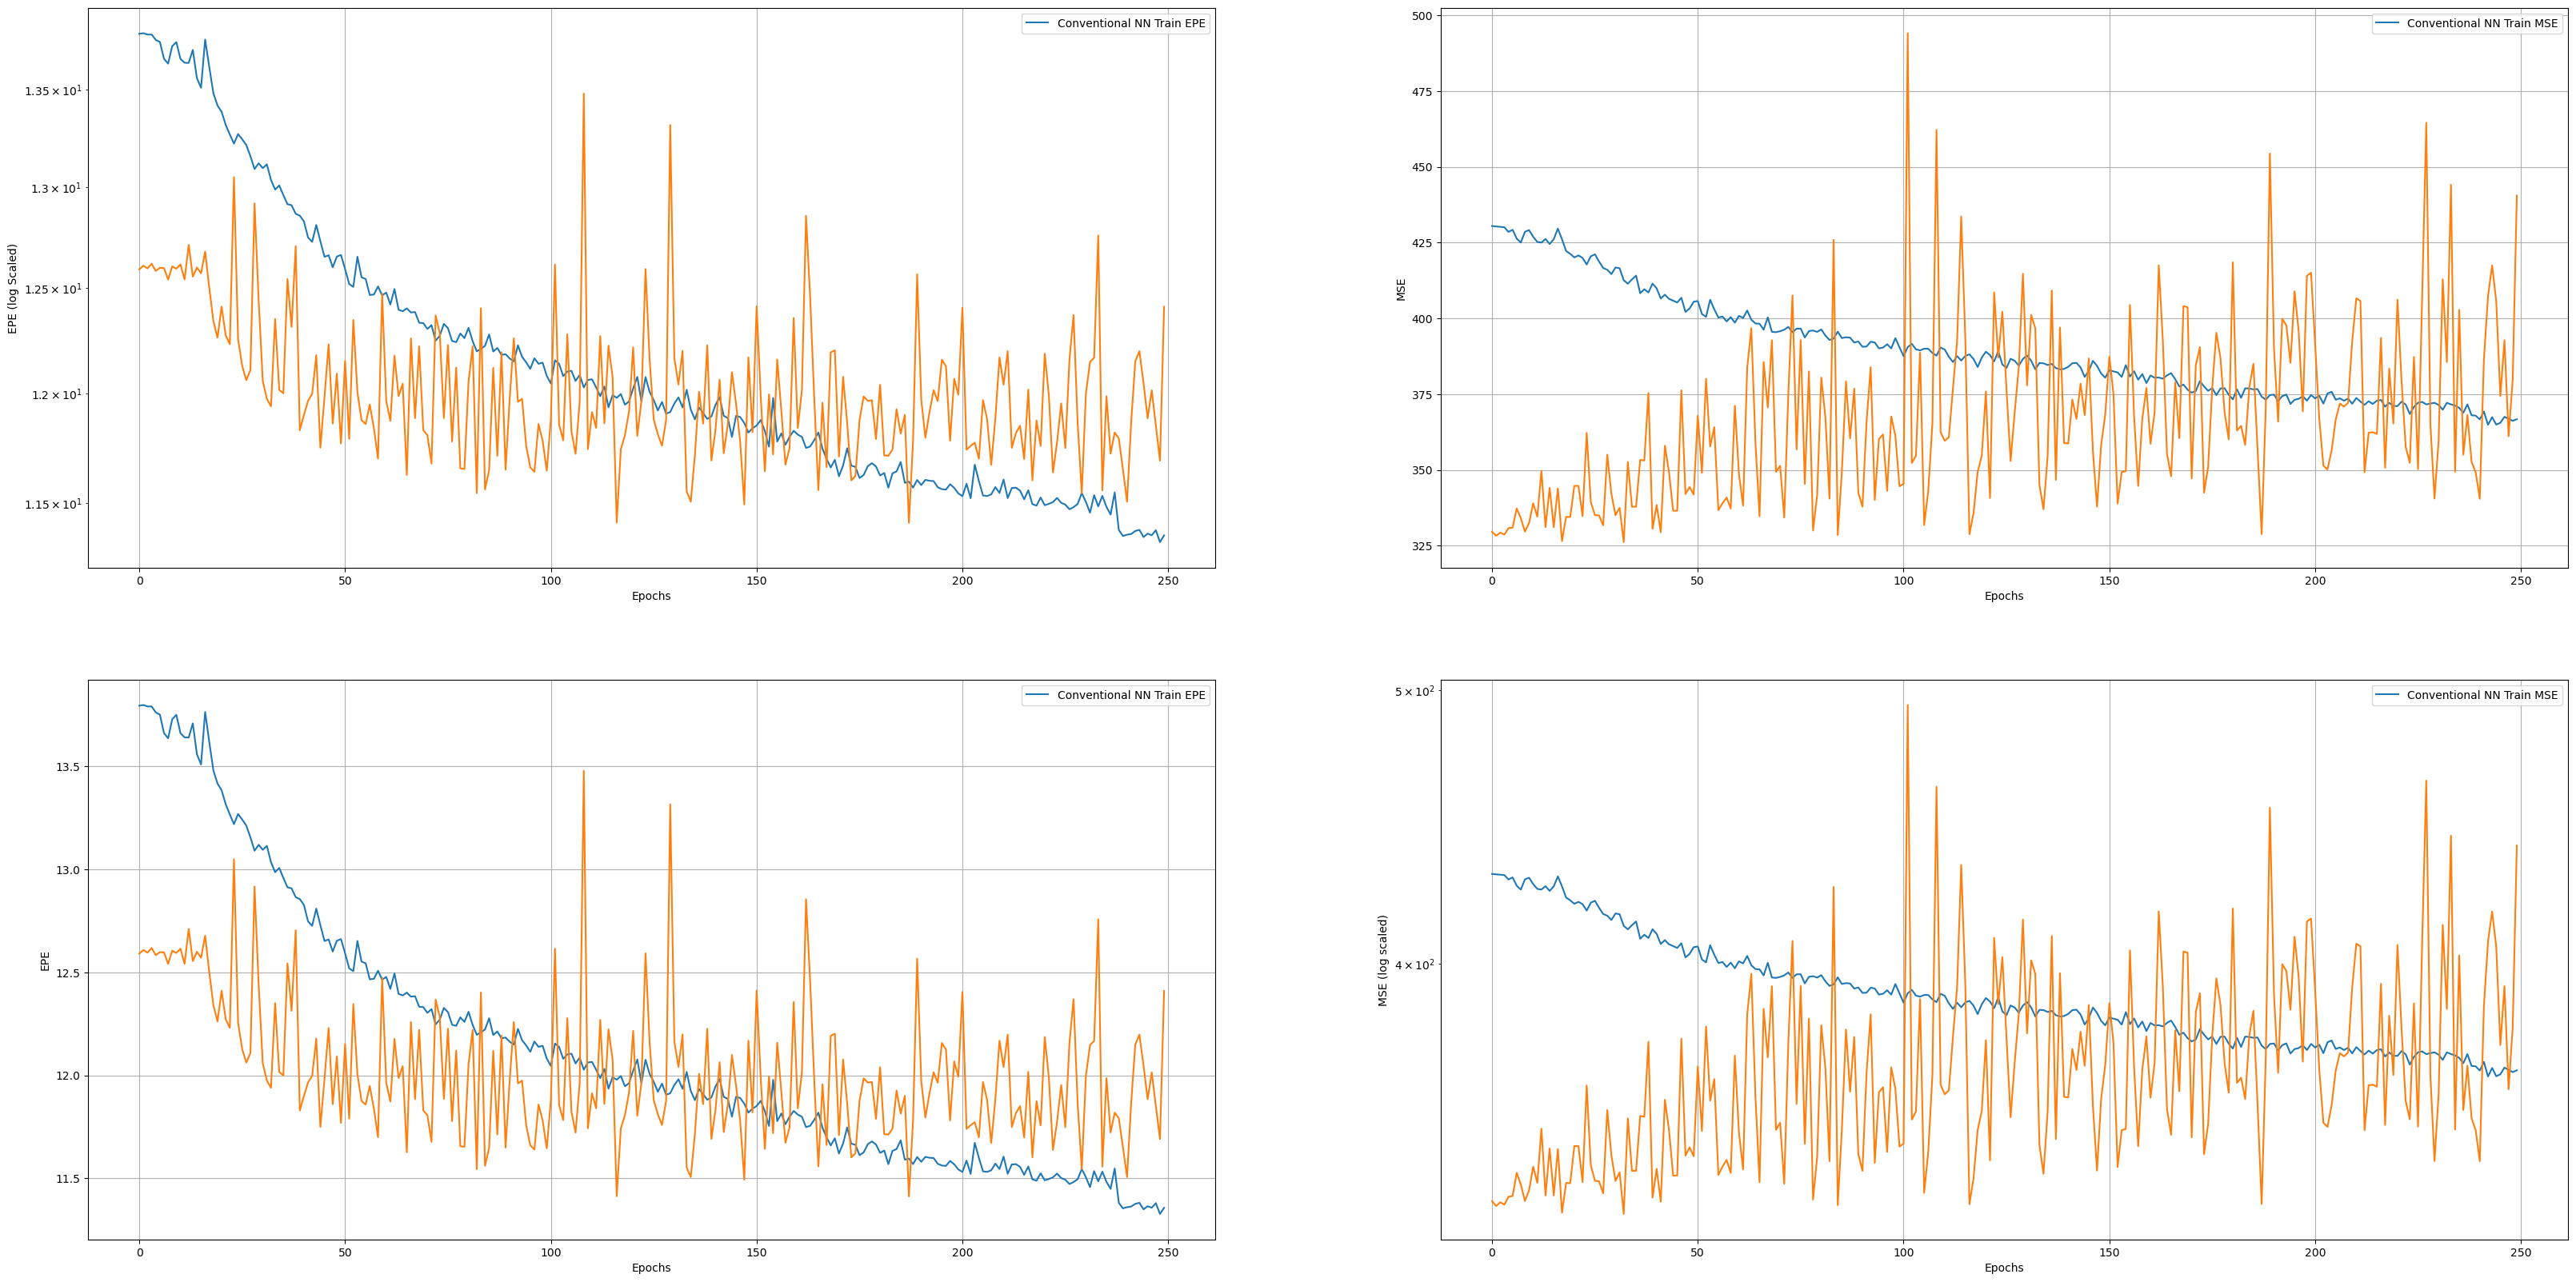

In [14]:
visualiseFits(hist)